##### Quantum Data Science 2021/2022
## Lecture 3 - Data Encoding

## Contents

1. [Introduction](#intro)
2. [Important Functions](#important)
3. [Basis Encoding](#basis_encoding)
4. [Amplitude Encoding](#amplitude_encoding)
5. [Angle Encoding](#angle_encoding)
6. [IQP Encoding](#iqp_encoding)    

### 1. Introduction
<a id="intro"></a>

<p align="center">
  <img width="300" height="300" src="images/qml_types.png">
</p>

There are four main approaches to combine machine learning with quantum computing, depending on the data and device being classical or quantum. 
  - **CC** - Classical data with classical device. However, it refers to classical algorithms that were inspired by quantum information techniques. E.g. Tensor Networks. 
  - **QC** - Classical Machine Learning on quantum data i.e., quantum states. E.g. Neural networks to describe quantum states. 
  - **CQ** - Classical data processed by quantum device - Quantum-enhanced Machine Learning. E.g. QNN's , Groverized solutions ... 
  - **QQ** - Quantum data processed by quantum device - *TRUE* Quantum Machine Learning 

  This course will be focused on the **CQ** setting. For that reason, we need to understand data loading and data processing strategies. Furthermore, during this course we are going to notice that the data encoding strategy is crucial for the capability of the algorithm. Notwithstanding, all the algorithms learned during this course can be easily adapted to the **QQ** setting, simply by removing the data encoding subroutine.

  <span style="color: orange;">NOTATION</span>: <br>
        - $n$ is the number of qubits.<br>
        - $M$ is the number of datapoints in a dataset.<br>
        - $N$ is the number of *features*.<br>

### 2. Important functions and libraries <a id="important"></a>

###### again

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
### EXECUTE CIRCUIT ###
def execute_circuit(qc, shots=1024, device=None):
    if device is None:
        device = Aer.get_backend('qasm_simulator')
    else:
        device = device
    
    circ_trans = transpile(qc,device)
    counts = device.run(circ_trans, shots=shots).result().get_counts()
    
    return counts

### BASIS STATES PROBABILITIES ###
def basis_states_probs(counts, shots=1024, n_qubits=1):
   probs = []
   basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

   for b in basis_states:
      c = counts.get(b)
      if c is None:
         probs.append(0)
      else:
         probs.append(counts[b]/shots)


   return probs


### 3. Basis Encoding <a id="basis_encoding"></a>

Basis encoding associates a classical $n$-bit string with a computational basis state of a $n$-qubit system. For instance if we have the binary string $b = (b_1 b_2 \dots b_n)$ where $b_i \in \{0,1\}$ the mapping to a quantum state is:

$$ b = (b_1 b_2 \dots b_n) \mapsto |b\rangle = | b_1 b_2 \dots b_n \rangle $$ 

Specifically, if we have a binary dataset $D_{b} = \{x^1 , x^2, \dots , x^M \} $ where $M$ is the total number of examples in the dataset and $x^i \in \{0,1\}^n$. We can create the superposition of all examples in the dataset, represented as:

$$ |D_b\rangle = \frac{1}{\sqrt{M}} \sum_{i=0}^{M-1} |x^i\rangle$$ 

which can be represented in a quantum circuit by applying $n$ Hadamard gates, creating the uniform superposition state

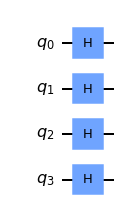

In [7]:
qc = QuantumCircuit(4)
qc.h(range(4))
qc.draw(output = "mpl")

However, if the dataset contains repeated elements this circuit will not work. For instance, the dataset
$$ D_b = \{ 0111, 0101, 0111\}$$ 

is represented by the quantum state:

$$ |D_b\rangle = \frac{1}{\sqrt{3}}|0101\rangle + \frac{2}{\sqrt{3}}|0111\rangle$$


Now, notice that the dataset usually is an arbitrary *real* dataset, and not *binary*. Thus, for real datapoints $x_i$, to encode the dataset into the quantum system, we need to find the maximum element of the dataset and convert it to binary to see how many qubits $n$ do we need.

$$n \approx \lceil log_2 max(D) \rceil$$

Furthermore, in the context of machine learning remember that each datapoint is composed by $N$ features: 

$$ x^i = \{x^i_0, \dots, x^i_{N-1}\}$$

thus, we actually need to find the maximum for each feature in every datapoint. The number of qubits that we need to represent each feature $i$ is :

$$ n_{i} \approx \lceil log_2 max(D_{i}) \rceil $$

where $D_{i}$ is the set of all features $i$ in present in dataset $D$. The quantum state will have $n_i$ qubits allocated for each feature $i$.

Thus, we need $n$ total qubits: 

$$n = \sum_{i=0}^{N-1} n_i$$



For $M$ datapoints with $N$ features each, a superposition of the dataset will be created using an auxillary quantum register with $m$ qubits as:

$$ m \approx \lceil log_2 M \rceil $$

s.t it will help to create the quantum datapoint $|x_i\rangle$ conditionally on the the state of the auxiliary register $|i\rangle$ as: 

\begin{equation}
    \frac{1}{\sqrt{M}} \sum_{i=1}^M |i\rangle |0\rangle^n \mapsto \frac{1}{\sqrt{M}} \sum_{i=1}^M |i\rangle |x_i\rangle
\end{equation}

<span style="color: red;">EXERCISE 3.1</span> - Create the Unitary $U$ that creates the superposition an in Equation (1) for the dataset $x = \{x_1, x_2 \} = \{(1,3) , (2,3)\}$

Remember how to create an arbitrary controlled gate in qiskit: 

<p align="center">
  <img width="400" height="400" src="images/ctrl_gate.png">
</p>


In [ ]:
def basis_encoding(dataset):

    #quantum circuit
    ctrl = QuantumRegister(ctrl_qubits, "ctrl")
    features = QuantumRegister(feature_qubits, "features")
    qc = QuantumCircuit(ctrl,features)
    
    #create the controlled gate iteratively for each datapoint

    return qc

In [19]:
### SOLUTION ### 

def basis_encoding(dataset):

    #maximum in features (axis=0 are the columns) and conversion to list
    max_features=dataset.max(axis=0).tolist()
    
    #conversion to binary for the maximum element
    feature_bin = np.array([len(np.binary_repr(f)) for f in max_features])

    #total number of qubits for features 
    feature_qubits = np.sum(feature_bin)

    #number of control qubits - dependent on the number of elements on the dataset
    ctrl_qubits = int(np.ceil(np.log2(len(dataset))))
    #quantum circuit
    ctrl = QuantumRegister(ctrl_qubits, "ctrl")
    features = QuantumRegister(feature_qubits, "features")
    qc = QuantumCircuit(ctrl,features)
    
    #create the controlled gate iteratively for each datapoint
    for ([x,y],i) in zip(dataset,range(len(dataset))):
        qc1 = QuantumCircuit(feature_qubits, name = "$x^{} - ({},{})$".format(i,x,y))
        x_bin = np.binary_repr(x, width = feature_bin[0])
        y_bin = np.binary_repr(y, width = feature_bin[1])
        feature = x_bin + y_bin

        for q in range(feature_qubits):
            if int(feature[q]):
                qc1.x(q)

        #verify if the number of control qubits >=1 because if not, the dataset has a single datapoint and we don't need to have control
        if not ctrl_qubits:
            a = qc1.to_gate()
        else:
            a = qc1.to_gate().control(ctrl_qubits,ctrl_state=np.binary_repr(i))
        qc.append(a, [i for i in ctrl] + [i for i in features])

    return qc

1


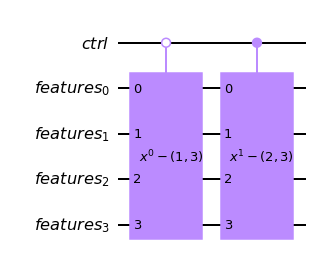

In [22]:
qc = basis_encoding(np.array([[1,3],[2,3]]))
qc.draw(output="mpl")

### 4. Amplitude Encoding <a id="amplitude_encoding"></a>

Amplitude encoding encodes data into the amplitudes of a quantum state. Suppose we have a datapoint with $N$ features $x=(x_0, x_1, \dots , x_{N-1})$. The amplitude encoded quantum state will be a  $\lceil log N \rceil$ qubit state in which each basis state will have an amplitude corresponding to the *normalized* feature $\hat{x_i}$ as:

$$ |x\rangle = \sum_{i=1}^{N} \hat{x_i} |i\rangle$$

such that the normalization is:  

$$ \hat{x_i} = \sqrt{\frac{x_i}{\sum_{i=1}^{N} x_i}}$$

i.e. $\sum_{i=1}^{N} |\hat{x_i}|^2 = 1$


<span style="color: red;">EXERCISE 4.1</span> - For simplicity, let's work the *example 4.1* of the book *Machine Learning with quantum computers*. The goal is instead of encoding a datapoint , encoding a probability distribution over the basis states. Encode the following quantum state: 

$$ |\psi\rangle = \sqrt{0.2}|000\rangle +  \sqrt{0.5}|010\rangle +  \sqrt{0.2}|110\rangle +  \sqrt{0.1}|111\rangle $$

In [5]:
def get_angle(s,j, x):
    a=0
    b=0
    for l in range(2**(s-1)):
        a+=x[(2*j - 1)*(2**(s-1)) + l]
    for l in range(2**s):
        b+=x[(j - 1)*(2**s) + l]

    if b==0:
        return 0
    else:
        return 2*np.arcsin(np.sqrt(a/b))


In [ ]:
from qiskit.circuit.library.standard_gates import RYGate

def mottonen(x, is_normalized=False):

    norm = 0 
    n_qubits = 
    
    if is_normalized:
        x_normalized = x
    else:
        x_normalized = x/np.sum(x)
        
    qc = QuantumCircuit()

    '''
    for ...
    '''

    angle = get_angle()
    
    return qc
    

In [25]:
### Solution ###
from qiskit.circuit.library.standard_gates import RYGate

def mottonen(x, is_normalized=False):

    n_qubits = int(np.ceil(np.log2(len(x))))
    len_x = len(x)

    #padding
    if len_x < 2**n_qubits:
        x = np.append(x,np.zeros(2**n_qubits - len_x))

    if is_normalized:
        x_normalized = x
    else:
        x_normalized = x/np.sum(x)
    
    qr = QuantumRegister(n_qubits,"qr")
    qc = QuantumCircuit(qr)

    for (s,qb) in zip(range(1,n_qubits),reversed(range(1,n_qubits))):
        x_bin_rev = [np.binary_repr(j,width=qb)[::-1] for j in range(2**qb)]
        
        for j in range(len(x_bin_rev)):
            
            ctrl = x_bin_rev[j]
            angle = get_angle(s,j+1, x_normalized)
            ccry = RYGate(angle).control(len(ctrl),ctrl_state=ctrl)
            qc.append(ccry, [qr[i] for i in range(qb+1)])
    

    ## last element , single qubit ry rotation
    angle = get_angle(n_qubits, 1, x_normalized)
    qc.ry(angle, qr[0])

    return qc.inverse()

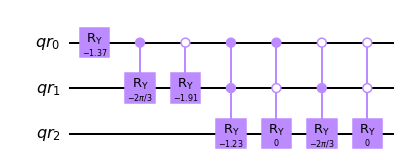

In [26]:
a = np.array([0.2,0.0,0.1,0.3,0.1,0.0,0.2,0.1],dtype=object)
circuit = mottonen(a, is_normalized=True)
circuit.draw(output="mpl")

#### Execute the circuit and plot the histogram 

In [27]:
circuit.measure_all()
counts = execute_circuit(circuit, shots=8000)
counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())


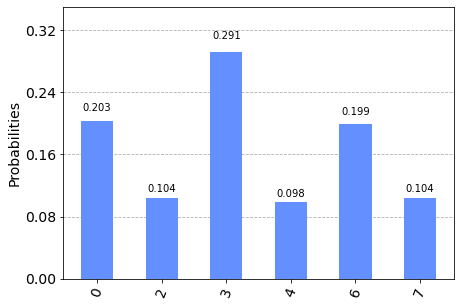

In [28]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

### You can compare the ouput of your function with qiskit initialize function

In [17]:
a = np.array([0.2,0.0,0.1,0.3,0.1,0.0,0.2,0.1])
a = np.sqrt(a)
qc = QuantumCircuit(3)
qc.initialize(a, [0,1,2])


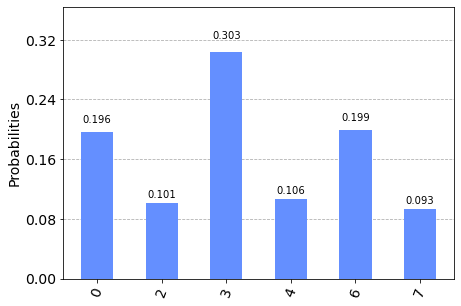

In [18]:
qc.measure_all()
counts = execute_circuit(qc, shots=8000)
counts = dict((int(a,2),b) for (a,b) in counts.items())
plot_histogram(counts)

<span style="color: orange;">HOMEWORK</span> - Create the amplitude encoded quantum state for the *single* datapoint $x = (2,3,1,11,23)$, following the *Motonnen* algorithm 

Now, remember that for a dataset $D$ with $M$ datapoints with $N$ features each, amplitude encoding needs an extra $\lceil log M \rceil$ qubit state for representing the superposition of the entire dataset. The generalized quantum amplitude encoded state is represented as:

$$ |D\rangle = \frac{1}{\sqrt{M}} \sum_{j=1}^{M} \sum_{i=1}^{N} \hat{x_i} |j\rangle |i\rangle$$ 

Thus, this encoding strategy needs at most $\lceil log NM \rceil$ qubits.

##### Did you notice how BORING it is to do everything by hand ??? But wait a minute!!!! Can we use the **initialize** function to create an arbitrary quantum state ? Well, yes, but keep in mind that it's going to work only for a single data point, and not for the entire dataset. Why? 


<p align="center">
  <img width="600" height="500" src="images/resets.jpg">
</p>

##### Do you notice something strange? 



##### We cannot do a control reset , because reset is not a gate !

##### However, instead of doing the entire superposition in parallel , controlled by the extra quantum registers we could concatenate every datapoint and encode it in a single sweep , as in the following example. 

<p align="center">
  <img width="600" height="600" src="images/concat.png">
</p>

##### BUT take into account that in this way we will not be acting in each point individually, but in the *mixture*.

### 5. Angle Encoding <a id="angle_encoding"></a>

In *Angle Encoding* we encode each feature of a single datapoint in a single qubit, using simple *Pauli* rotation gates. For a point with $N$ features, $x = \{x_0, \dots, x_{N-1} \}$, angle encoding needs $N$ qubits and encode each feature as: 

$$ |x\rangle = \bigotimes_{i=0}^{N-1} e^{i x_i \sigma}|0\rangle$$

where $\sigma \in \{\sigma_x, \sigma_y, \sigma_z\}$ is the complete Pauli gate set.

For $\sigma = \sigma_y$ the encoding becomes:

$$ |x\rangle = \bigotimes_{i=0}^{N-1} cos(x_i)|0\rangle + sin(x_i) |1\rangle$$

Notice that this is a periodic encoding strategy. This means that we need to be sure that each feature is *normalized* in the range $[-\pi, \pi]$.

<span style="color: red;">EXERCISE 5.1</span> - Create the angle encoded quantum state for the *single* datapoint $x = (2,3,1,11,23)$, for $\sigma = \sigma_y$.

The $L_{\infty}$ normalization normalizes each feature by the maximum absolute feature present in the datapoint i.e. for x = \{x_1, \dots, x_N \}$: 
$$|x|_{\infty} = max_{i} |x_i|$$

s.t the normalized feature $x_i$ becomes: 

$$ \hat{x_i} = \frac{x_i}{|x|_{\infty}}$$

This way each feature stays in the range $[-1,1]$. Use the $L_{\infty}$ normalization strategy.

In [ ]:
def angle_encoding(x, sigma="y"):

    max_abs_feature = 
    x_normalized = 
    n_qubits = 
    qc = QuantumCircuit(n_qubits)

    return qc

In [117]:
### SOLUTION ### 
def angle_encoding(x, sigma="y"):
    
    max_abs_feature = np.max(np.abs(x))
    x_normalized = x/max_abs_feature
    n_qubits = len(x)

    features = QuantumRegister(n_qubits,"feature")
    qc = QuantumCircuit(features)

    for i in range(len(x_normalized)):
        angle = 2*x_normalized[i]
        if sigma == "y":
            qc.ry(angle, features[i])
        if sigma == "x":
            qc.rx(angle, features[i])
        if sigma == "z":
            qc.rz(angle, features[i])

    return qc

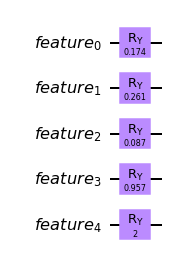

In [118]:
x = np.array([2,3,1,11,23])
qc = angle_encoding(x)
qc.draw(output="mpl")

There is also a strategy called **Dense Angle Encoding** where the goal is to reduce the number of qubits in angle encoding. It is a slight generalization of angle encoding, that encodes two features per qubit using the relative phase as: 

$$ |x\rangle = \bigotimes_{i=1}^{\lceil N/2\rceil} cos(x_{2i-1})|0\rangle + e^{jx_{2i}}sin(x_{2i-1}) |1\rangle $$

<span style="color: orange;">HOMEWORK</span>  - Implement Dense Angle Encoding

### 6. IQP Encoding <a id="iqp_encoding"></a>

*IQP - Instantaneous Quantum Polynomial circuits* - Complex encoding strategy. Hadamard gates + Angle encoding (with $\sigma_z$ rotation) + controlled rotations for pairs of features. For $N$ features $x=\{x_0, \dots, x_{N-1}\}$ the encoding works on $N$ qubits as:

$$ |x\rangle = (U(x) H^{\otimes N})^r |0\rangle$$

where 

$$U(x) = \prod_{i,j \in x} e^{j (\pi - x_i)(\pi - x_j) \sigma_{z_i} \otimes \sigma_{z_j}} \bigotimes_{i=0}^{N-1} e^{j x_i \sigma_z}$$

where $r$ is the number of repetitions of the the encoding.
In essence , the circuit is as follows:

<p align="center">
  <img width="1000" height="200" src="images/iqp.png">
</p>

REMEMBER! The reason for iqp encoding is that this type of circuits are hard to simulate classically which may be a form of quantum advantage when used in quantum machine learning models.


 <span style="color: red;">EXERCISE 6.1</span> - Create the IQP encoded quantum state for the *single* datapoint $x = (2,3,1,11,23)$. Use $L_{\infty}$ normalization. 

In [ ]:
def iqp_encoding(x, r=1):
    n_qubits = 

    return qc

In [125]:
### SOLUTION ###
def iqp_encoding(x, r=1):
    n_qubits = len(x)
    
    max_abs_feature = np.max(np.abs(x))
    x_normalized = x/max_abs_feature

    features = QuantumRegister(n_qubits)
    qc = QuantumCircuit(features)

    for rep in range(r):
        qc.h(features)
        angle_encoding_block = angle_encoding(x_normalized, sigma="z")
        angle_encoding_block.name = "angle encoding"
        qc.append(angle_encoding_block, [i for i in features])
        
        for q1 in range(n_qubits-1):
            for q2 in range(q1+1,n_qubits):
                qc.cx(q1, q2)
                qc.rz(2*(np.pi-x_normalized[q1])*(np.pi - x_normalized[q2]), features[q2])
                qc.cx(q1, q2)
                qc.barrier()
    return qc

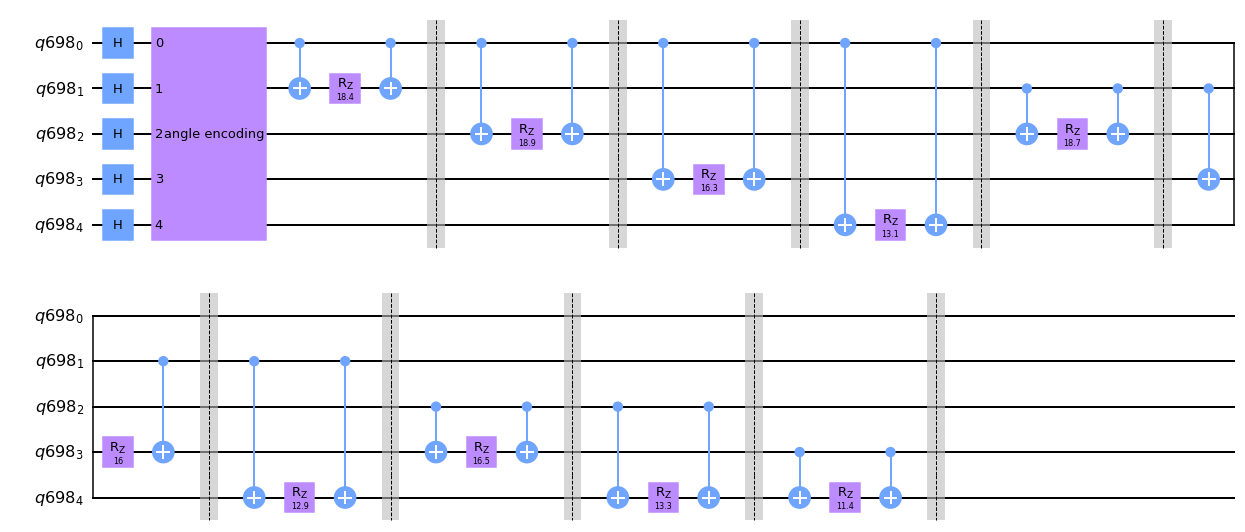

In [126]:
x = np.array([2,3,1,11,23])
qc = iqp_encoding(x, r=1)
qc.draw(output="mpl")

### GREAT NEWS !!!! Qiskit has a built in function for IQP encoding ! The **ZZFeatureMap** function

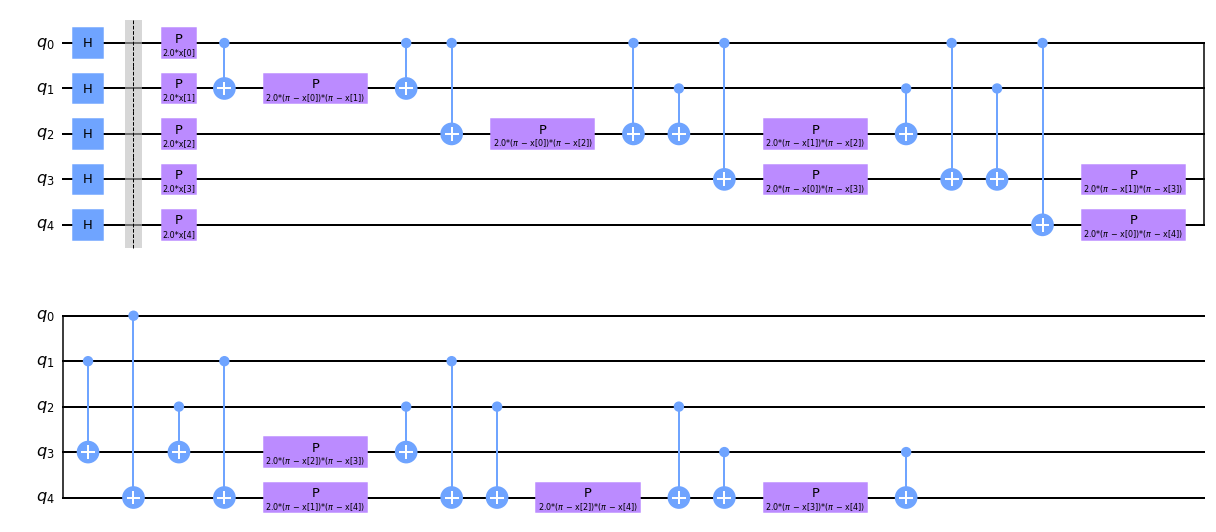

In [128]:
from qiskit.circuit.library import ZZFeatureMap

#ZZFeatureMap(n_qubits, reps=1, insert_barriers=True)
circuit = ZZFeatureMap(5, reps=1, insert_barriers=True)
circuit.decompose().draw(output="mpl")

Then you can bind the quantum circuit to a given datapoint !

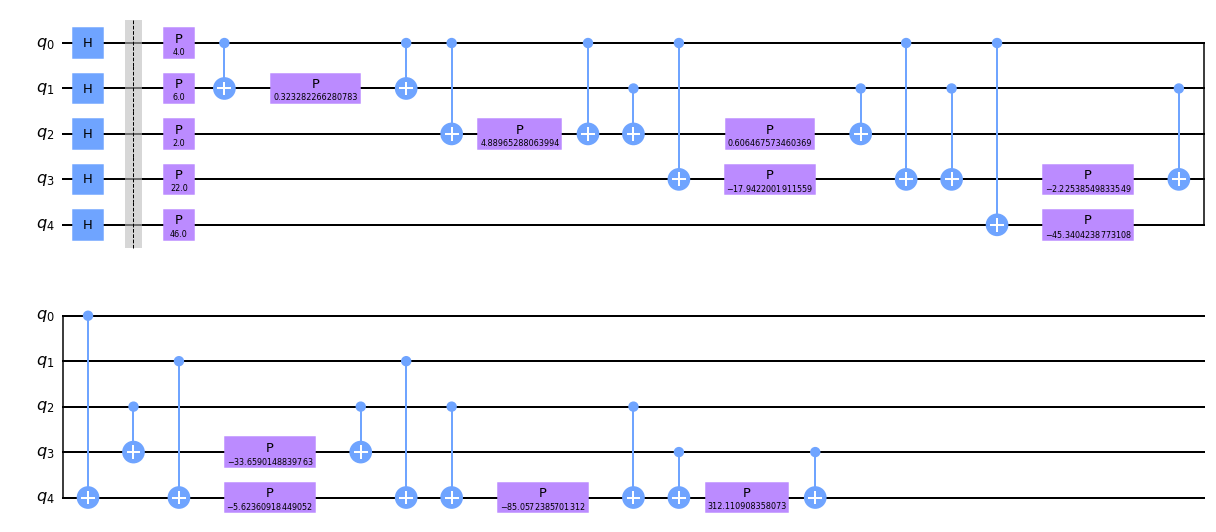

In [129]:
x = np.array([2,3,1,11,23])
### DON'T forget to normalize the dataset
encode = circuit.bind_parameters(x)
encode.decompose().draw(output="mpl")